## Simple Ver

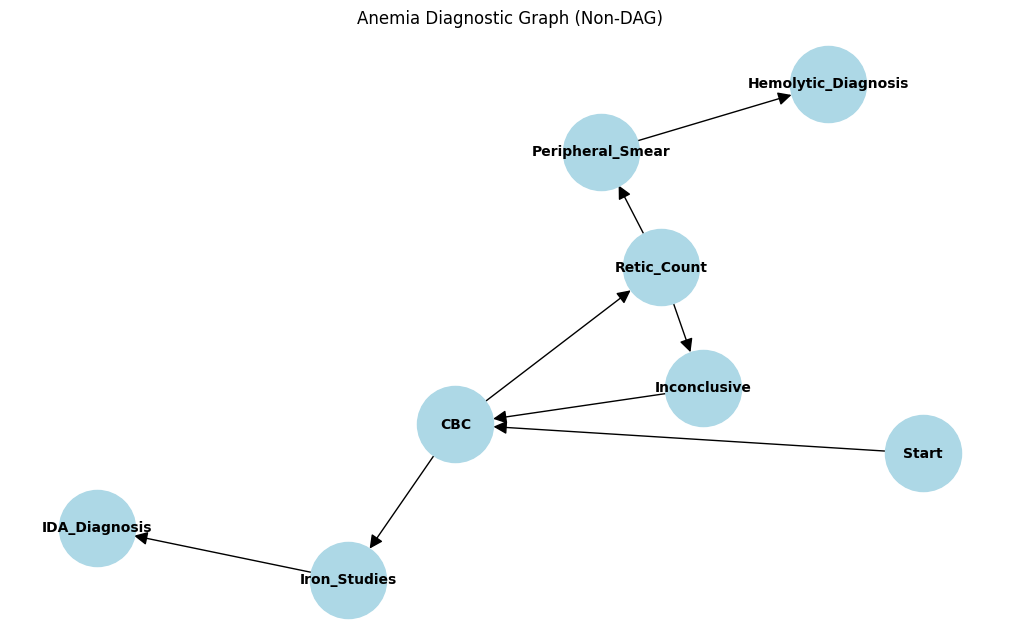

In [1]:
import networkx as nx
import matplotlib.pyplot as plt

# 1. Create a Directed Graph object (allows for cycles)
G = nx.DiGraph()

# 2. Add edges (this automatically creates the nodes)
edges = [
    ("Start", "CBC"),
    ("CBC", "Retic_Count"), ("CBC", "Iron_Studies"),
    ("Retic_Count", "Peripheral_Smear"), ("Retic_Count", "Inconclusive"),
    ("Inconclusive", "CBC"), # The Cycle!
    ("Peripheral_Smear", "Hemolytic_Diagnosis"),
    ("Iron_Studies", "IDA_Diagnosis")
]
G.add_edges_from(edges)

# 3. Draw the graph
plt.figure(figsize=(10, 6))
pos = nx.spring_layout(G)  # Positions nodes using a force-directed algorithm

nx.draw(G, pos, with_labels=True, node_color='lightblue', 
        node_size=3000, arrowsize=20, font_size=10, font_weight='bold')

plt.title("Anemia Diagnostic Graph (Non-DAG)")
plt.show()

In [2]:
import random
# Define edge weights (transition probabilities)
edge_probabilities = {
    ("Start", "CBC"): 1.0,  # Always start with CBC
    ("CBC", "Retic_Count"): 0.4,
    ("CBC", "Iron_Studies"): 0.6,
    ("Retic_Count", "Peripheral_Smear"): 0.7,
    ("Retic_Count", "Inconclusive"): 0.3,
    ("Inconclusive", "CBC"): 1.0,  # Cycle back
    ("Peripheral_Smear", "Hemolytic_Diagnosis"): 1.0,
    ("Iron_Studies", "IDA_Diagnosis"): 1.0
}

# Add weights to graph
for edge, prob in edge_probabilities.items():
    G[edge[0]][edge[1]]['weight'] = prob

# Modified sampling function
def generate_weighted_path(G, start_node="Start", terminal_nodes=None,
                          min_steps=4, max_steps=7):
    """Generate path using weighted random sampling."""
    if terminal_nodes is None:
        terminal_nodes = set()
    
    path = [start_node]
    current_node = start_node
    
    for step in range(max_steps):
        successors = list(G.successors(current_node))
        if not successors:
            break
        
        # Get weights for each successor
        weights = [G[current_node][succ].get('weight', 1.0) 
                   for succ in successors]
        
        # Sample based on weights
        next_node = random.choices(successors, weights=weights)[0]
        path.append(next_node)
        current_node = next_node
        
        if current_node in terminal_nodes and len(path) >= min_steps:
            break
    
    return path, current_node in terminal_nodes

In [4]:
def generate_k_paths(G, k=100, **kwargs):
    """Generate K patient pathways."""
    paths = []
    for i in range(k):
        path, is_complete = generate_weighted_path(G, **kwargs)
        paths.append({
            'path': path,
            'is_complete': is_complete,
            'length': len(path)
        })
    return paths

# Usage
terminal_nodes = {"IDA_Diagnosis", "Hemolytic_Diagnosis"}
k_paths = generate_k_paths(G, k=10, 
                          start_node="Start",
                          terminal_nodes=terminal_nodes,
                          min_steps=4, max_steps=7)

## Advanced Ver

In [15]:
def generate_path_with_guaranteed_diagnosis(G, start_node="Start", 
                                           terminal_nodes=None,
                                           min_steps=4, max_steps=6,
                                           max_attempts=100):
    """
    Generate path that ALWAYS ends at a terminal diagnosis.
    Uses cycle detection and backtracking to avoid infinite loops.
    """
    if terminal_nodes is None:
        terminal_nodes = set()
    
    path = [start_node]
    current_node = start_node
    cycle_count = {}  # Track how many times we visit each node
    
    for attempt in range(max_attempts):
        # Get successors
        successors = list(G.successors(current_node))
        
        if not successors:
            # Dead end - restart path
            path = [start_node]
            current_node = start_node
            cycle_count = {}
            continue
        
        # Get weights for sampling
        weights = [G[current_node][succ].get('weight', 1.0) 
                   for succ in successors]
        
        # Penalize nodes we've visited too many times (avoid infinite cycles)
        adjusted_weights = []
        for succ, w in zip(successors, weights):
            visits = cycle_count.get(succ, 0)
            # Exponentially reduce probability for repeated visits
            penalty = 0.5 ** visits if visits > 0 else 1.0
            adjusted_weights.append(w * penalty)
        
        # Sample next node
        next_node = random.choices(successors, weights=adjusted_weights)[0]
        path.append(next_node)
        current_node = next_node
        
        # Update cycle tracking
        cycle_count[current_node] = cycle_count.get(current_node, 0) + 1
        
        # Check if reached terminal diagnosis
        if current_node in terminal_nodes:
            # Ensure minimum length requirement
            if len(path) >= min_steps:
                return path
            # If too short, continue (though this is rare with min_steps=4)
        
        # Check if path is getting too long
        if len(path) > max_steps:
            # Force towards terminal nodes if possible
            terminal_successors = [s for s in successors if s in terminal_nodes]
            if terminal_successors:
                path.append(random.choice(terminal_successors))
                return path
    
    # Fallback: if max_attempts reached, find shortest path to any terminal
    return force_terminal_diagnosis(G, path, terminal_nodes)

def force_terminal_diagnosis(G, current_path, terminal_nodes):
    """
    Fallback: append shortest path from current position to any terminal node.
    """
    current_node = current_path[-1]
    
    # Try to find shortest path to any terminal node
    for terminal in terminal_nodes:
        try:
            shortest = nx.shortest_path(G, current_node, terminal)
            # Append remaining path (skip first node as it's already in path)
            return current_path + shortest[1:]
        except nx.NetworkXNoPath:
            continue
    
    # If no path exists, this indicates graph structure issue
    # Return path as-is and log warning
    print(f"Warning: No path from {current_node} to any terminal node")
    return current_path

In [16]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import numpy as np
from collections import defaultdict

# 1. Create expanded graph with more tests
G = nx.DiGraph()

# Define edges with more comprehensive anemia workup
edges = [
    # Initial screening (everyone starts here)
    ("Start", "CBC"),
    
    # From CBC - analyze cell size
    ("CBC", "MCV_Analysis"),
    
    # === MICROCYTIC PATHWAY (low MCV < 80) ===
    ("MCV_Analysis", "Iron_Studies"),
    ("Iron_Studies", "Ferritin_Test"),
    
    # Low ferritin → IDA
    ("Ferritin_Test", "TIBC_Test"),
    ("TIBC_Test", "IDA_Diagnosis"),
    
    # Normal/high ferritin → check for other causes
    ("Ferritin_Test", "Hemoglobin_Electrophoresis"),
    ("Hemoglobin_Electrophoresis", "Thalassemia_Diagnosis"),
    ("Hemoglobin_Electrophoresis", "Chronic_Disease_Anemia_Diagnosis"),
    
    # === MACROCYTIC PATHWAY (high MCV > 100) ===
    ("MCV_Analysis", "B12_Folate_Test"),
    
    # Vitamin deficiency found
    ("B12_Folate_Test", "Methylmalonic_Acid_Test"),
    ("Methylmalonic_Acid_Test", "B12_Deficiency_Diagnosis"),
    ("B12_Folate_Test", "Folate_Deficiency_Diagnosis"),
    
    # No vitamin deficiency → check bone marrow
    ("B12_Folate_Test", "Bone_Marrow_Biopsy"),
    ("Bone_Marrow_Biopsy", "MDS_Diagnosis"),
    ("Bone_Marrow_Biopsy", "Aplastic_Anemia_Diagnosis"),
    
    # === NORMOCYTIC PATHWAY (normal MCV 80-100) ===
    ("MCV_Analysis", "Reticulocyte_Count"),
    
    # High reticulocyte → hemolysis
    ("Reticulocyte_Count", "LDH_Test"),
    ("LDH_Test", "Haptoglobin_Test"),
    ("Haptoglobin_Test", "Hemolytic_Anemia_Diagnosis"),
    ("Haptoglobin_Test", "Coombs_Test"),  # If autoimmune suspected
    ("Coombs_Test", "Autoimmune_Hemolytic_Diagnosis"),
    
    # Low reticulocyte → production problem
    ("Reticulocyte_Count", "EPO_Level_Test"),
    ("EPO_Level_Test", "Chronic_Kidney_Disease_Anemia_Diagnosis"),
    ("EPO_Level_Test", "Chronic_Disease_Anemia_Diagnosis"),
    
    # Inconclusive → further workup
    ("EPO_Level_Test", "Bone_Marrow_Biopsy"),
    ("LDH_Test", "Peripheral_Blood_Smear"),
    ("Peripheral_Blood_Smear", "Bone_Marrow_Biopsy"),
    
    # === CYCLES (for inconclusive/borderline results) ===
    ("MCV_Analysis", "Repeat_CBC"),
    ("Repeat_CBC", "CBC"),
    
    ("Iron_Studies", "Repeat_Iron_Panel"),
    ("Repeat_Iron_Panel", "Ferritin_Test"),
    
    ("Reticulocyte_Count", "Repeat_Reticulocyte"),
    ("Repeat_Reticulocyte", "Reticulocyte_Count"),
]

# Add edges for path diversity
additional_edges = [
    # Direct shortcuts (confident diagnosis)
    ("CBC", "IDA_Diagnosis"),
    ("MCV_Analysis", "IDA_Diagnosis"),
    ("Iron_Studies", "IDA_Diagnosis"),
    ("B12_Folate_Test", "B12_Deficiency_Diagnosis"),
    ("Reticulocyte_Count", "Hemolytic_Anemia_Diagnosis"),
    
    # Alternative orderings
    ("CBC", "Reticulocyte_Count"),
    ("CBC", "Iron_Studies"),
    ("CBC", "B12_Folate_Test"),
    ("MCV_Analysis", "Bone_Marrow_Biopsy"),
    
    # Cross-pathway jumps (hypothesis changes)
    ("Iron_Studies", "Reticulocyte_Count"),
    ("Reticulocyte_Count", "Iron_Studies"),
    ("B12_Folate_Test", "Iron_Studies"),
]

G.add_edges_from(edges)
G.add_edges_from(additional_edges)


# 2. Define terminal diagnosis nodes
terminal_nodes = {
    "IDA_Diagnosis",                          # Iron deficiency
    "Thalassemia_Diagnosis",                  # Genetic
    "Chronic_Disease_Anemia_Diagnosis",       # Inflammation
    "B12_Deficiency_Diagnosis",               # Vitamin B12
    "Folate_Deficiency_Diagnosis",            # Vitamin B9
    "MDS_Diagnosis",                          # Myelodysplastic syndrome
    "Aplastic_Anemia_Diagnosis",              # Bone marrow failure
    "Hemolytic_Anemia_Diagnosis",             # RBC destruction
    "Autoimmune_Hemolytic_Diagnosis",         # Autoimmune
    "Chronic_Kidney_Disease_Anemia_Diagnosis" # CKD-related
}

# 3. Add edge weights (transition probabilities based on clinical likelihood)
edge_probabilities = {
    ("Start", "CBC"): 1.0,
    
    # === FROM CBC - now has shortcuts ===
    ("CBC", "MCV_Analysis"): 0.85,        # Reduced from 1.0
    ("CBC", "Reticulocyte_Count"): 0.05,  # NEW - skip MCV
    ("CBC", "Iron_Studies"): 0.05,        # NEW - skip MCV
    ("CBC", "IDA_Diagnosis"): 0.03,       # NEW - obvious IDA
    ("CBC", "B12_Folate_Test"): 0.02,     # NEW - rare jump
    
    # === FROM MCV_Analysis - now has shortcuts ===
    ("MCV_Analysis", "Iron_Studies"): 0.50,        # Reduced from 0.60
    ("MCV_Analysis", "Reticulocyte_Count"): 0.20,  # Reduced from 0.25
    ("MCV_Analysis", "B12_Folate_Test"): 0.12,     # Reduced from 0.15
    ("MCV_Analysis", "Repeat_CBC"): 0.08,          # Reduced from 0.10
    ("MCV_Analysis", "IDA_Diagnosis"): 0.05,       # NEW - clear microcytic
    ("MCV_Analysis", "Bone_Marrow_Biopsy"): 0.05,  # NEW - severe case
    
    # === FROM Iron_Studies - now has shortcuts ===
    ("Iron_Studies", "Ferritin_Test"): 0.70,         # Reduced from 0.85
    ("Iron_Studies", "Repeat_Iron_Panel"): 0.10,     # Reduced from 0.15
    ("Iron_Studies", "IDA_Diagnosis"): 0.10,         # NEW - very low iron
    ("Iron_Studies", "Reticulocyte_Count"): 0.05,    # NEW - hypothesis change
    ("Iron_Studies", "B12_Folate_Test"): 0.05,       # NEW - hypothesis change
    
    # === Ferritin unchanged ===
    ("Ferritin_Test", "TIBC_Test"): 0.70,
    ("Ferritin_Test", "Hemoglobin_Electrophoresis"): 0.30,
    
    ("TIBC_Test", "IDA_Diagnosis"): 1.0,
    ("Hemoglobin_Electrophoresis", "Thalassemia_Diagnosis"): 0.60,
    ("Hemoglobin_Electrophoresis", "Chronic_Disease_Anemia_Diagnosis"): 0.40,
    
    # === FROM B12_Folate_Test - now has shortcut ===
    ("B12_Folate_Test", "Methylmalonic_Acid_Test"): 0.35,  # Reduced from 0.40
    ("B12_Folate_Test", "Folate_Deficiency_Diagnosis"): 0.25,  # Reduced from 0.30
    ("B12_Folate_Test", "Bone_Marrow_Biopsy"): 0.25,           # Reduced from 0.30
    ("B12_Folate_Test", "B12_Deficiency_Diagnosis"): 0.10,     # NEW - very low B12
    ("B12_Folate_Test", "Iron_Studies"): 0.05,                 # NEW - hypothesis change
    
    ("Methylmalonic_Acid_Test", "B12_Deficiency_Diagnosis"): 1.0,
    ("Bone_Marrow_Biopsy", "MDS_Diagnosis"): 0.50,
    ("Bone_Marrow_Biopsy", "Aplastic_Anemia_Diagnosis"): 0.50,
    
    # === FROM Reticulocyte_Count - now has shortcuts ===
    ("Reticulocyte_Count", "LDH_Test"): 0.45,              # Reduced from 0.50
    ("Reticulocyte_Count", "EPO_Level_Test"): 0.35,        # Reduced from 0.40
    ("Reticulocyte_Count", "Repeat_Reticulocyte"): 0.08,   # Reduced from 0.10
    ("Reticulocyte_Count", "Hemolytic_Anemia_Diagnosis"): 0.07,  # NEW - obvious hemolysis
    ("Reticulocyte_Count", "Iron_Studies"): 0.05,          # NEW - hypothesis change
    
    ("LDH_Test", "Haptoglobin_Test"): 0.80,
    ("LDH_Test", "Peripheral_Blood_Smear"): 0.20,
    ("Haptoglobin_Test", "Hemolytic_Anemia_Diagnosis"): 0.60,
    ("Haptoglobin_Test", "Coombs_Test"): 0.40,
    ("Coombs_Test", "Autoimmune_Hemolytic_Diagnosis"): 1.0,
    ("EPO_Level_Test", "Chronic_Kidney_Disease_Anemia_Diagnosis"): 0.50,
    ("EPO_Level_Test", "Chronic_Disease_Anemia_Diagnosis"): 0.30,
    ("EPO_Level_Test", "Bone_Marrow_Biopsy"): 0.20,
    ("Peripheral_Blood_Smear", "Bone_Marrow_Biopsy"): 1.0,
    
    # Cycles
    ("Repeat_CBC", "CBC"): 1.0,
    ("Repeat_Iron_Panel", "Ferritin_Test"): 1.0,
    ("Repeat_Reticulocyte", "Reticulocyte_Count"): 1.0,
}


In [17]:
for edge, prob in edge_probabilities.items():
    if G.has_edge(edge[0], edge[1]):
        G[edge[0]][edge[1]]['weight'] = prob


# 5. Generate one example path
print("\n=== Generating Example Path ===")
example_path = generate_path_with_guaranteed_diagnosis(
    G, 
    start_node="Start",
    terminal_nodes=terminal_nodes,
    min_steps=4,
    max_steps=7
)

print(f"Path length: {len(example_path)}")
print(f"Path: {' → '.join(example_path)}")
print(f"Ends at diagnosis: {example_path[-1] in terminal_nodes}")

# 6. Generate K paths
def generate_k_paths(G, k=1000, **kwargs):
    """Generate K patient pathways, all ending at diagnosis."""
    paths = []
    for i in range(k):
        if i % 100 == 0:
            print(f"Generated {i}/{k} paths...")
        path = generate_path_with_guaranteed_diagnosis(G, **kwargs)
        paths.append({
            'path': path,
            'length': len(path),
            'diagnosis': path[-1]
        })
    return paths

print("\n=== Generating 1000 Paths ===")
k_paths = generate_k_paths(
    G, 
    k=1000,
    start_node="Start",
    terminal_nodes=terminal_nodes,
    min_steps=4,
    max_steps=6
)

# 7. Analyze generated paths
print("\n=== Path Statistics ===")
lengths = [p['length'] for p in k_paths]
print(f"Average path length: {np.mean(lengths):.2f} ± {np.std(lengths):.2f}")
print(f"Min length: {min(lengths)}, Max length: {max(lengths)}")

diagnosis_counts = defaultdict(int)
for p in k_paths:
    diagnosis_counts[p['diagnosis']] += 1

print("\n=== Diagnosis Distribution ===")
for diagnosis, count in sorted(diagnosis_counts.items(), key=lambda x: x[1], reverse=True):
    print(f"{diagnosis}: {count} ({count/len(k_paths)*100:.1f}%)")



=== Generating Example Path ===
Path length: 7
Path: Start → CBC → MCV_Analysis → Iron_Studies → Ferritin_Test → TIBC_Test → IDA_Diagnosis
Ends at diagnosis: True

=== Generating 1000 Paths ===
Generated 0/1000 paths...
Generated 100/1000 paths...
Generated 200/1000 paths...
Generated 300/1000 paths...
Generated 400/1000 paths...
Generated 500/1000 paths...
Generated 600/1000 paths...
Generated 700/1000 paths...
Generated 800/1000 paths...
Generated 900/1000 paths...

=== Path Statistics ===
Average path length: 6.53 ± 1.13
Min length: 4, Max length: 9

=== Diagnosis Distribution ===
IDA_Diagnosis: 451 (45.1%)
Hemolytic_Anemia_Diagnosis: 134 (13.4%)
Chronic_Disease_Anemia_Diagnosis: 92 (9.2%)
Thalassemia_Diagnosis: 71 (7.1%)
Aplastic_Anemia_Diagnosis: 61 (6.1%)
B12_Deficiency_Diagnosis: 57 (5.7%)
MDS_Diagnosis: 52 (5.2%)
Chronic_Kidney_Disease_Anemia_Diagnosis: 39 (3.9%)
Folate_Deficiency_Diagnosis: 31 (3.1%)
Autoimmune_Hemolytic_Diagnosis: 12 (1.2%)


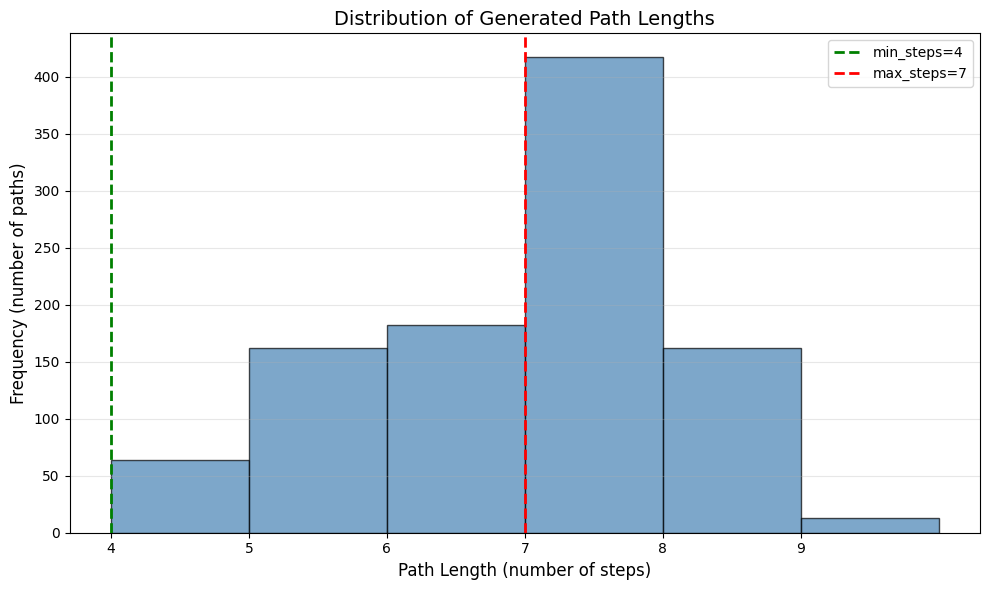

In [13]:
import matplotlib.pyplot as plt

# Create histogram
plt.figure(figsize=(10, 6))
plt.hist(lengths, bins=range(min(lengths), max(lengths)+2), 
         edgecolor='black', alpha=0.7, color='steelblue')
plt.xlabel('Path Length (number of steps)', fontsize=12)
plt.ylabel('Frequency (number of paths)', fontsize=12)
plt.title('Distribution of Generated Path Lengths', fontsize=14)
plt.xticks(range(min(lengths), max(lengths)+1))
plt.grid(axis='y', alpha=0.3)

# Add vertical lines for min_steps and max_steps
plt.axvline(x=4, color='green', linestyle='--', linewidth=2, label='min_steps=4')
plt.axvline(x=7, color='red', linestyle='--', linewidth=2, label='max_steps=7')
plt.legend()

plt.tight_layout()
plt.show()

/var/folders/68/9s90bfzn3bb1pktzv3rswtkw0000gn/T/ipykernel_5336/2086343189.py:21: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


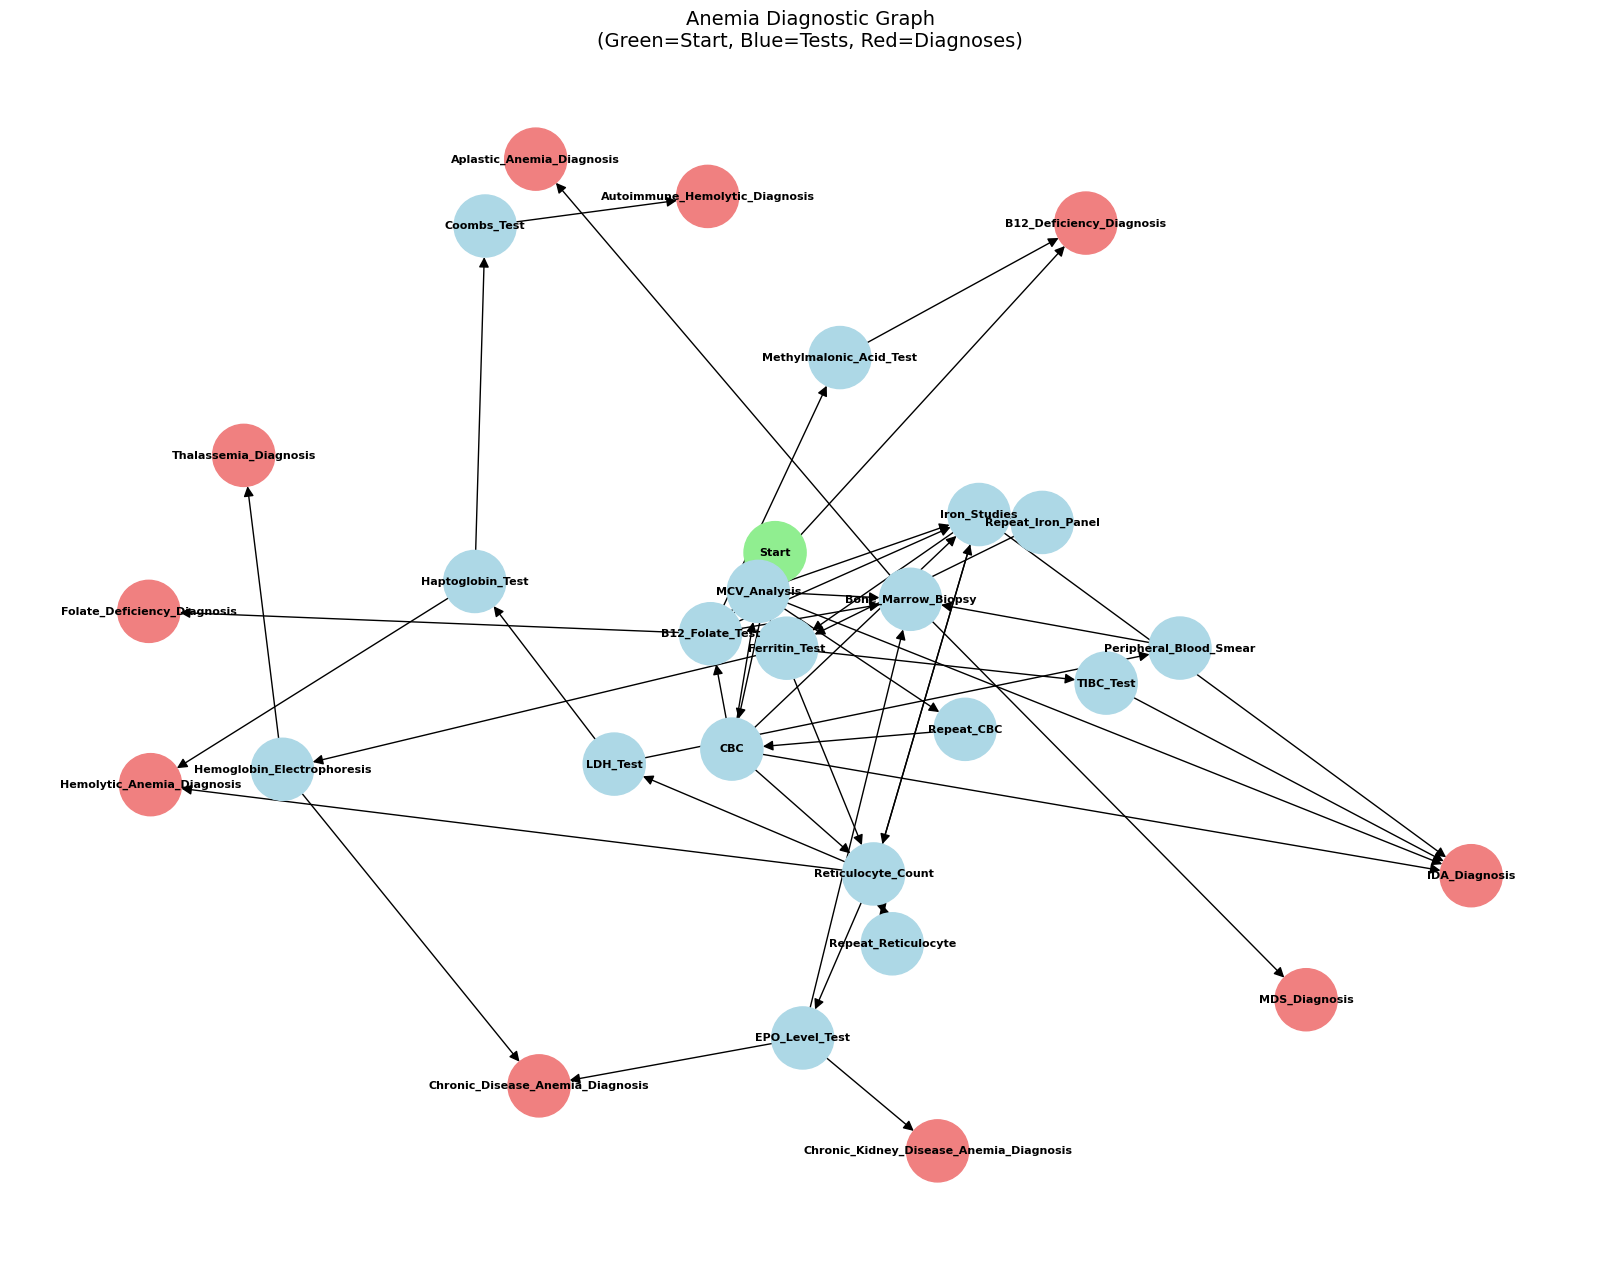

In [14]:
# 8. Visualize the graph
plt.figure(figsize=(16, 12))
pos = nx.spring_layout(G, k=0.5, iterations=50, seed=42)

# Color nodes by type
node_colors = []
for node in G.nodes():
    if node == "Start":
        node_colors.append('lightgreen')
    elif node in terminal_nodes:
        node_colors.append('lightcoral')
    else:
        node_colors.append('lightblue')

nx.draw(G, pos, with_labels=True, node_color=node_colors,
        node_size=2000, arrowsize=15, font_size=8, 
        font_weight='bold', arrows=True)

plt.title("Anemia Diagnostic Graph\n(Green=Start, Blue=Tests, Red=Diagnoses)", 
          fontsize=14)
plt.tight_layout()
plt.show()

In [18]:
import pandas as pd
# Convert to DataFrame
paths_data = []
for i, path_dict in enumerate(k_paths):
    paths_data.append({
        'path_id': i,
        'length': path_dict['length'],
        'diagnosis': path_dict['diagnosis'],
        'path': ' -> '.join(path_dict['path'])  # Human-readable
    })

df = pd.DataFrame(paths_data)

# Save to CSV
df.to_csv('anemia_paths.csv', index=False)
print(f"Exported {len(df)} paths to anemia_paths.csv")

Exported 1000 paths to anemia_paths.csv


In [23]:
import numpy as np
from collections import defaultdict

def extract_transition_matrix(k_paths, G):
    """
    Extract transition probability matrix from K generated paths.
    
    Returns:
        - transition_matrix: numpy array (n_nodes x n_nodes)
        - node_to_idx: dict mapping node names to matrix indices
        - idx_to_node: dict mapping indices to node names
        - transition_counts: raw counts for inspection
    """
    # Get all unique nodes from the graph
    all_nodes = list(G.nodes())
    n_nodes = len(all_nodes)
    
    # Create mappings
    node_to_idx = {node: i for i, node in enumerate(sorted(all_nodes))}
    idx_to_node = {i: node for node, i in node_to_idx.items()}
    
    # Count transitions
    transition_counts = defaultdict(lambda: defaultdict(int))
    
    for path_dict in k_paths:
        path = path_dict['path']
        # Count each transition in the path
        for i in range(len(path) - 1):
            from_node = path[i]
            to_node = path[i + 1]
            transition_counts[from_node][to_node] += 1
    
    # Convert counts to probability matrix
    transition_matrix = np.zeros((n_nodes, n_nodes))
    
    for from_node, to_dict in transition_counts.items():
        from_idx = node_to_idx[from_node]
        total_transitions = sum(to_dict.values())
        
        for to_node, count in to_dict.items():
            to_idx = node_to_idx[to_node]
            probability = count / total_transitions
            transition_matrix[from_idx, to_idx] = probability
    
    return transition_matrix, node_to_idx, idx_to_node, transition_counts


# Use it
transition_matrix, node_to_idx, idx_to_node, transition_counts = extract_transition_matrix(k_paths, G)
np.save('transition_matrix.npy', transition_matrix)
df_matrix = pd.DataFrame(
    transition_matrix,
    index=[idx_to_node[i] for i in range(len(idx_to_node))],
    columns=[idx_to_node[i] for i in range(len(idx_to_node))]
)
df_matrix.to_csv('transition_matrix.csv')

print(f"Transition matrix shape: {transition_matrix.shape}")
print(f"Number of nodes: {len(node_to_idx)}")

Transition matrix shape: (29, 29)
Number of nodes: 29


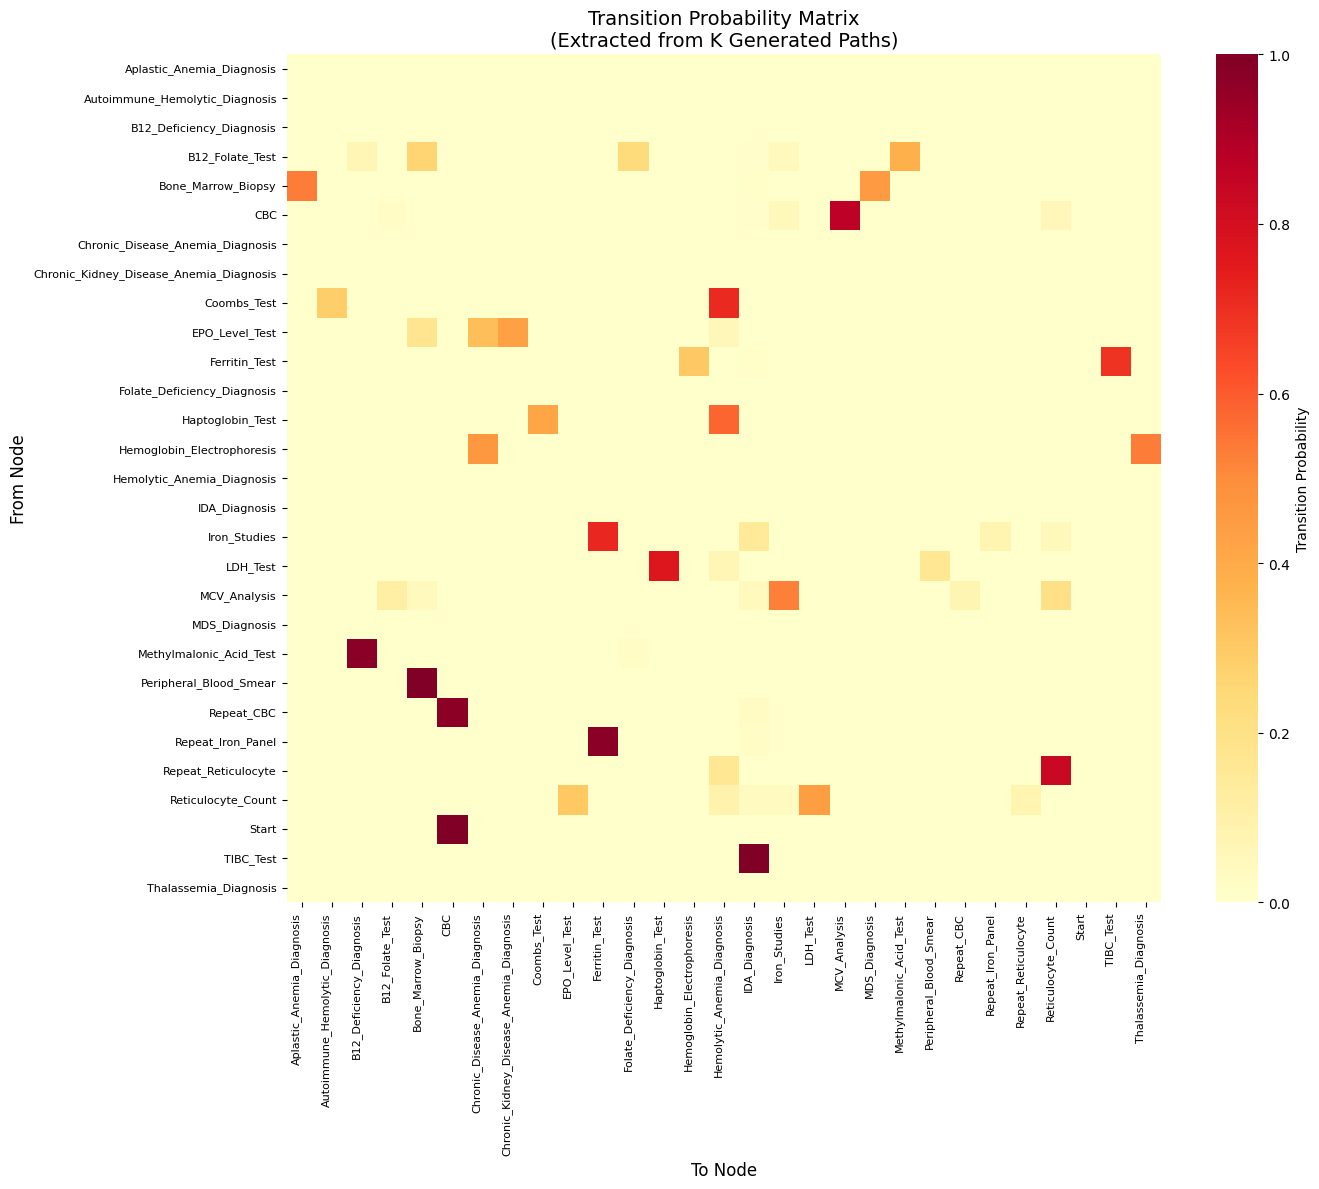

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create heatmap
plt.figure(figsize=(14, 12))

# Get node names in order
node_names = [idx_to_node[i] for i in range(len(idx_to_node))]

# Create heatmap with seaborn
sns.heatmap(transition_matrix, 
            xticklabels=node_names,
            yticklabels=node_names,
            cmap='YlOrRd',
            annot=False,  # Set True to show numbers (if not too many nodes)
            fmt='.2f',
            cbar_kws={'label': 'Transition Probability'})

plt.xlabel('To Node', fontsize=12)
plt.ylabel('From Node', fontsize=12)
plt.title('Transition Probability Matrix\n(Extracted from K Generated Paths)', fontsize=14)
plt.xticks(rotation=90, ha='right', fontsize=8)
plt.yticks(rotation=0, fontsize=8)
plt.tight_layout()
plt.show()